In [1]:
# importing initially essential packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

# 1. Acquiring Data

In [2]:
# download data from : https://www.kaggle.com/c/google-quest-challenge/data
!unzip '/content/drive/My Drive/AAIC Course/Personal case study 2  - Google Quest/google-quest-challenge.zip'

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.shape, df_test.shape

((6079, 41), (476, 11))

# 2. EDA :

### Problem Statement :
Given 3 text features - Question title, Qeustion body and Answer, we have to predict 30 target features.

In [4]:
# 1. basics about dataset
print("Total no.of 'questions' or 'datapoints' in dataset :", df_train.shape[0])
print("Total no.of 'features' in dataset :", df_train.shape[1])

Total no.of 'questions' or 'datapoints' in dataset : 6079
Total no.of 'features' in dataset : 41


In [5]:
# 2. names of the features in dataset and checking for any missing values in dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   qa_id                                  6079 non-null   int64  
 1   question_title                         6079 non-null   object 
 2   question_body                          6079 non-null   object 
 3   question_user_name                     6079 non-null   object 
 4   question_user_page                     6079 non-null   object 
 5   answer                                 6079 non-null   object 
 6   answer_user_name                       6079 non-null   object 
 7   answer_user_page                       6079 non-null   object 
 8   url                                    6079 non-null   object 
 9   category                               6079 non-null   object 
 10  host                                   6079 non-null   object 
 11  ques

In [6]:
# 3. find duplicate rows
df_train[df_train.duplicated()]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written


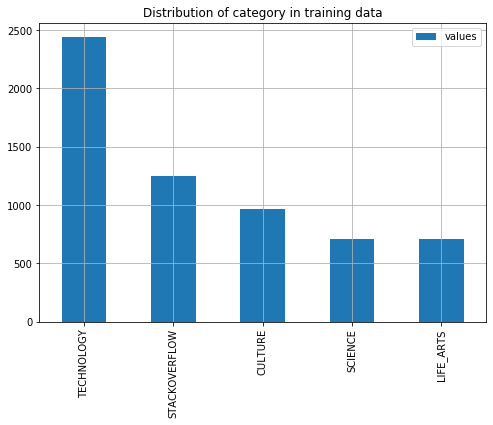

In [7]:
# 4. how many topics/categories are there in training dataset? and how its distributed?
val_cnt = df_train["category"].value_counts()
df = pd.DataFrame({'values': val_cnt.values
                  }, index = val_cnt.index)
df.plot(y = 'values', kind='bar', figsize=(8, 5.5), title='Distribution of category in training data')
plt.grid()
plt.show()

In [8]:
val_cnt[:20]

TECHNOLOGY       2441
STACKOVERFLOW    1253
CULTURE           963
SCIENCE           713
LIFE_ARTS         709
Name: category, dtype: int64

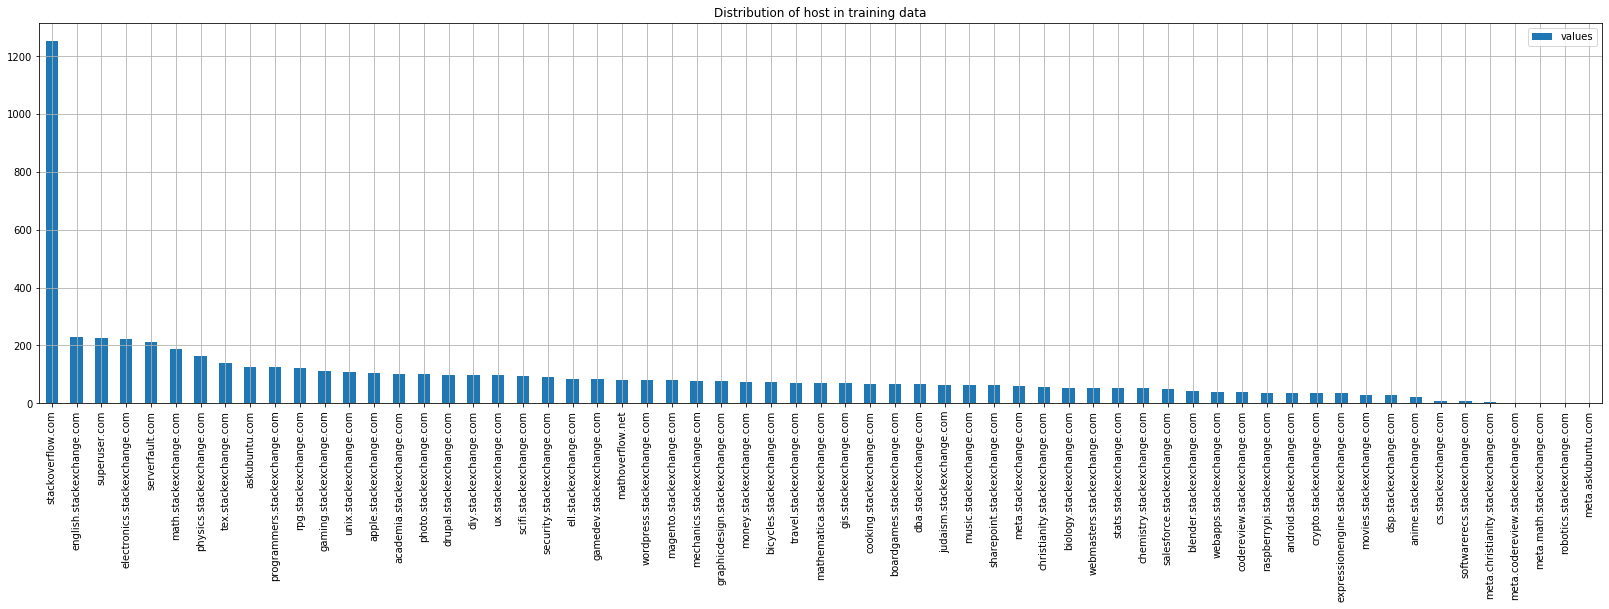

Total no. of hosting properties : 63


In [9]:
# 5. data coming from which stackexchange properties? and how its distributed?
val_cnt = df_train["host"].value_counts()
df = pd.DataFrame({'values': val_cnt.values
                  }, index = val_cnt.index)
df.plot( y = 'values', kind='bar', figsize=(28, 7), title='Distribution of host in training data')
plt.grid()
plt.show()
print('Total no. of hosting properties :', len(val_cnt))

In [10]:
# percentage wise top 10 properties
df = pd.DataFrame(val_cnt.head(10))
df['%'] = (val_cnt.values/sum(val_cnt.values))[:10]
print(df)
print('\n% datapoints coming from top 10 hosts: ', round(df['%'].sum()*100, 3))

                               host         %
stackoverflow.com              1253  0.206119
english.stackexchange.com       229  0.037671
superuser.com                   227  0.037342
electronics.stackexchange.com   221  0.036355
serverfault.com                 213  0.035039
math.stackexchange.com          187  0.030762
physics.stackexchange.com       164  0.026978
tex.stackexchange.com           140  0.023030
askubuntu.com                   126  0.020727
programmers.stackexchange.com   125  0.020563

% datapoints coming from top 10 hosts:  47.458


# Observations : Understanding the data
  * Category wise distribution is not so unbalanced, so it can be useful to train the model.
  * The most frequent host is the 'Stackoverflow' with 20.6% of the total hosting properties.
  * The group of Stackoverflow, english, superuser, electronics, serverfault, math, physics, tex, askubuntu, programmers together has almost 47.45% of the total questions.


### 1. Univariate analysis - Text feature : 'Title'

In [11]:
# Title token length
value = df_train['question_title'].values
title_len = [len(i.split(' ')) for i in value]

# 1. Basics - min, max, mean, median, quantiles
pd.DataFrame({'title_len' : title_len}).describe()

,title_len
count,6079.000000
mean,9.035861
std,3.775760
min,2.000000
25%,6.000000
50%,9.000000
75%,11.000000
max,28.000000


1. Word count in each question title has mean and median values of 9.035 and 9.00 respectively. Which states : usually question title contains 9 words in it.

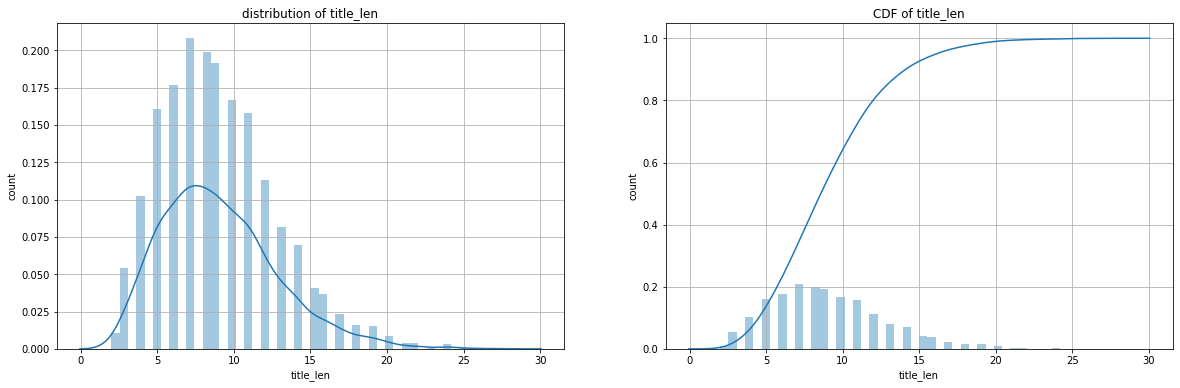

In [12]:
# 2. plotting PDF and CDF of 'Title_length'
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.distplot(title_len)
plt.grid()
plt.title('distribution of '+ 'title_len')
plt.xlabel('title_len')
plt.ylabel('count')

plt.subplot(1,2,2)
kwargs = {'cumulative': True}
sns.distplot(title_len, kde_kws=kwargs)
plt.grid()
plt.title('CDF of '+ 'title_len')
plt.xlabel('title_len')
plt.ylabel('count')
plt.show()

1. For sequential modelling it is crucial to know seuquence length and it's underlying distribution. Distribution of title_len seems reasonable and hence do not need much preprocessing steps before feed it into model.

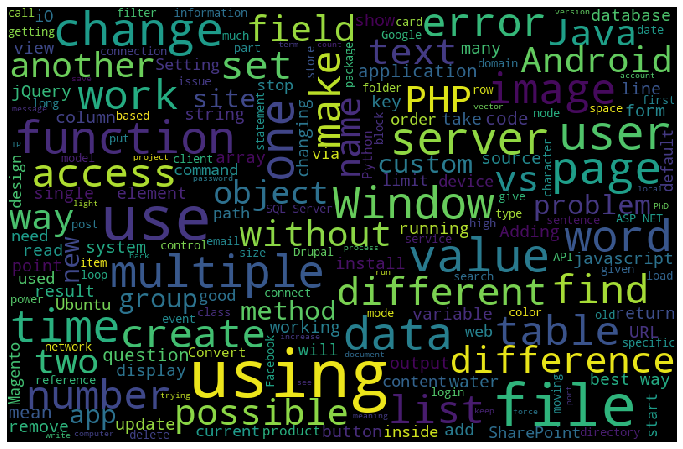

In [13]:
# 3. plotting wordcloud for Title feature
from wordcloud import WordCloud
string = ' '.join(df_train['question_title'].values)
title_wordcloud = WordCloud(width = 800, height = 533, repeat = False, max_font_size = 80).generate(string)

plt.figure(figsize = (12, 8)) 
plt.imshow(title_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show()

1. Question title mostly has technical words like 'file', 'error', 'function', 'server', 'error' etc.

2. This observation is very helpful in our task, since the state of the art sentence embeddings like BERT, XLnet are partially pretrained on some of the wikipedia technical articles too. if this was not so - transfer learning won't work with our task.

3. Question title contains few words like 'using', 'use' etc. we need to remove them as a text preprocessing step if needed. 

In [14]:
# 4. find duplicate question title
df_train[df_train['question_title'].duplicated()].shape

(2496, 41)

1. It is very important to note that 2496 question titles are duplicate out of 6079 question titles in total.

2. Duplicate datapoints does not add any value to ML models. Hence its better we remove duplicate rows from training data.

3. But, if we pass title along with any other features (like answer) then we do not need to remove the duplicate title rows. Hence better we keep it as is for now.

### 2. Univariate analysis - Text feature - 'Body'

In [15]:
# Body token length
value = df_train['question_body'].values
body_len = [len(i.split(' ')) for i in value]

# 1. basics
pd.DataFrame({'body_len' : body_len}).describe()

,body_len
count,6079.000000
mean,150.440204
std,228.709619
min,1.000000
25%,55.000000
50%,93.000000
75%,165.000000
max,4666.000000


* mean and median values of qustion body word count is 150 and 93, It's a significant gap between mean and median values since both of them are pointing towards central tendency of a random variable.

* This implies outliers i.e., long input sequences are corrupting the central tendencies of random variable(max = 4666).

* by truncating the input sequence we can avoid this issue.

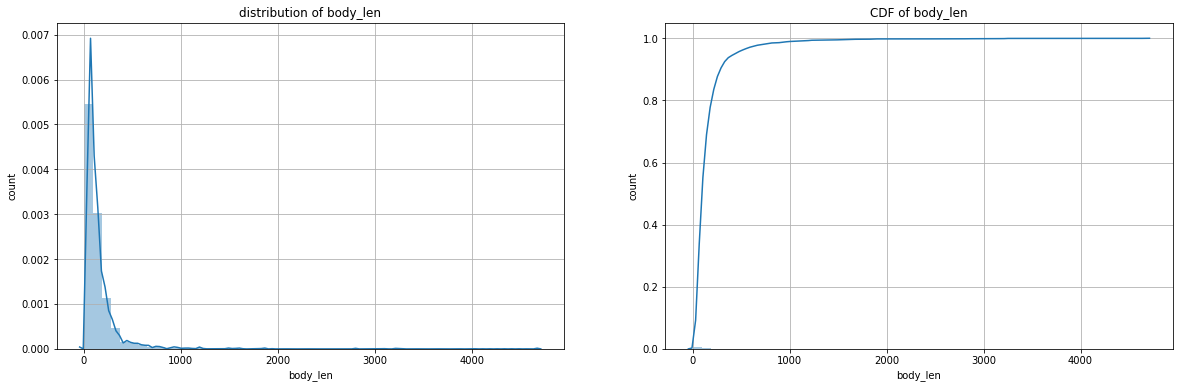

In [16]:
# 2. plotting PDF and CDF of 'Body_length'
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.distplot(body_len)
plt.grid()
plt.title('distribution of '+ 'body_len')
plt.xlabel('body_len')
plt.ylabel('count')

plt.subplot(1,2,2)
kwargs = {'cumulative': True}
sns.distplot(body_len, kde_kws=kwargs)
plt.grid()
plt.title('CDF of '+ 'body_len')
plt.xlabel('body_len')
plt.ylabel('count')
plt.show()

* Very skewed distribution unlike title_len, because of outlier seuquence lengths.

* This ensures we have to deal with outlier input sequences at model building stage.

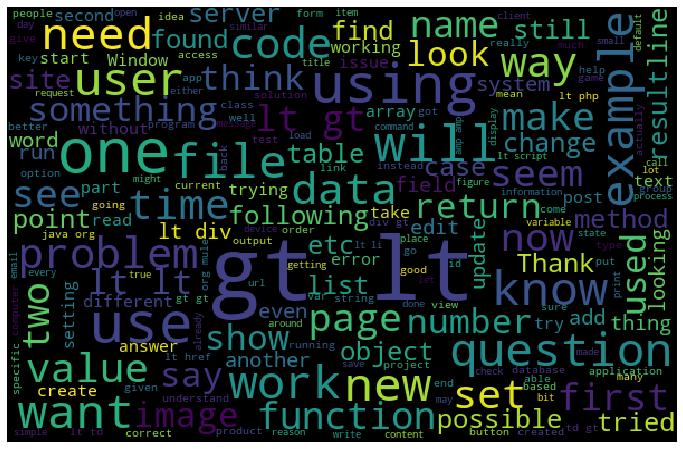

In [17]:
# 3. plotting wordcloud for body feature
from wordcloud import WordCloud
string = ' '.join(df_train['question_body'].values)
body_wordcloud = WordCloud(width = 600, height = 400, repeat = False, max_font_size = 80).generate(string)

plt.figure(figsize = (12, 8)) 
plt.imshow(body_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show()

In [18]:
dp = 50
df_train['question_body'].values[dp]

"I'm looking for an efficient way to encrypt multiple fields in a database with AES using a single global key, used throughout a large web application.\n\nObviously in order to re-use this key, a unique random IV is required for each field that is to be encrypted.\n\nI'd rather not introduce more fields to the database to store each of these IVs, so the programatic approach seems to be to derive these IVs some how.\n\nI'm toying with using either:\n\nkey = sha256(global_key + table_name)\niv = sha256(column_name + primary_key)\n\n\nOr even simply:\n\nkey = global_key\niv = sha256(table_name + column_name + primary_key)\n\n\nI'm leaning towards the former to generate per-table keys.\n\nI've already read that the IVs do not need to be kept secret. So I'm working on the assumption that a derived key or IV (even if the algorithm becomes known), is no more insecure than any other non-secret IV, as long as the original key remains secret.\n\nThe question is:\n\nIs there a fatal flaw in my ap

* frequently occuring words are quite similar to question_title. This confirms that question title and question body are very closely related features.

* unlike question_title, question body contains lots of white spaces, special characters, contractions etc. we need to take care of them at preprocessing stage.

* All the question-answer pairs resides on stackexchange network which are internet webpages and its obvious to have jquery or html language oriented keywords in our dataset. Hence we need to clean up question_body feature carefully.

In [19]:
# 4. find duplicate question body
df_train[df_train['question_body'].duplicated()].shape

(2496, 41)

* Duplicate question bodies are similar to duplicate question title. If we need to remove duplicate titles, we should remove duplicate bodies too. ofcourse by storing their indices incase we required to use them again.

### 3. Univariate analysis - Text feature - 'Answer'

In [20]:
# Title token length
value = df_train['answer'].values
answer_len = [len(i.split(' ')) for i in value]

# 1. basics
pd.DataFrame({'answer_len' : answer_len}).describe()

,answer_len
count,6079.000000
mean,143.708834
std,205.933584
min,2.000000
25%,48.000000
50%,91.000000
75%,170.000000
max,8158.000000


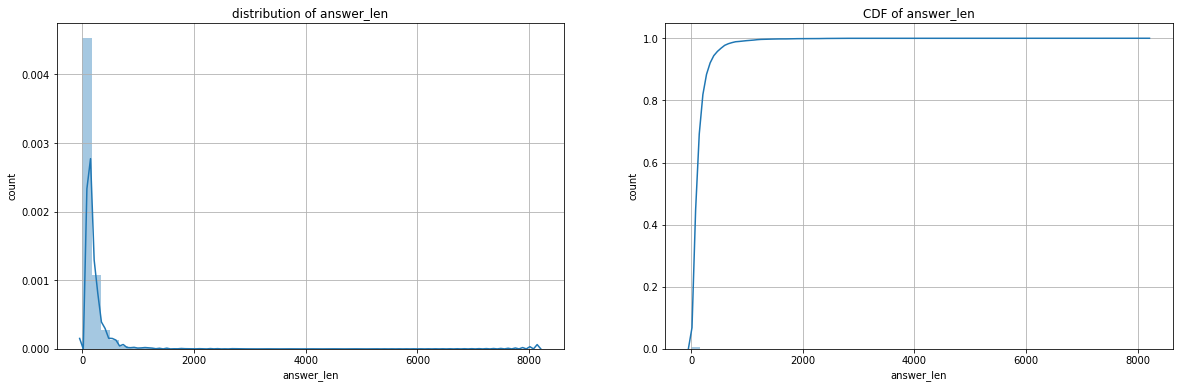

In [21]:
# 2. plotting PDF and CDF of 'Title_length'
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.distplot(answer_len)
plt.grid()
plt.title('distribution of '+ 'answer_len')
plt.xlabel('answer_len')
plt.ylabel('count')

plt.subplot(1,2,2)
kwargs = {'cumulative': True}
sns.distplot(answer_len, kde_kws=kwargs)
plt.grid()
plt.title('CDF of '+ 'answer_len')
plt.xlabel('answer_len')
plt.ylabel('count')
plt.show()

* Similar observations to 'question_body' feature : answer_len mean-median, distributions are curropted by outliers. If needed we can handle this while modelling by truncating the sequence.

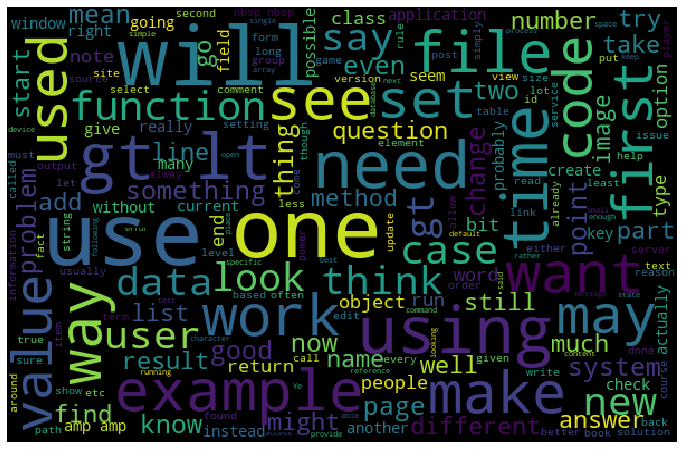

In [22]:
# 3. plotting wordcloud for Title feature
from wordcloud import WordCloud
string = ' '.join(df_train['answer'].values)
answer_wordcloud = WordCloud(width = 600, height = 400, repeat = False, max_font_size = 80).generate(string)

plt.figure(figsize = (12, 8)) 
plt.imshow(answer_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show()

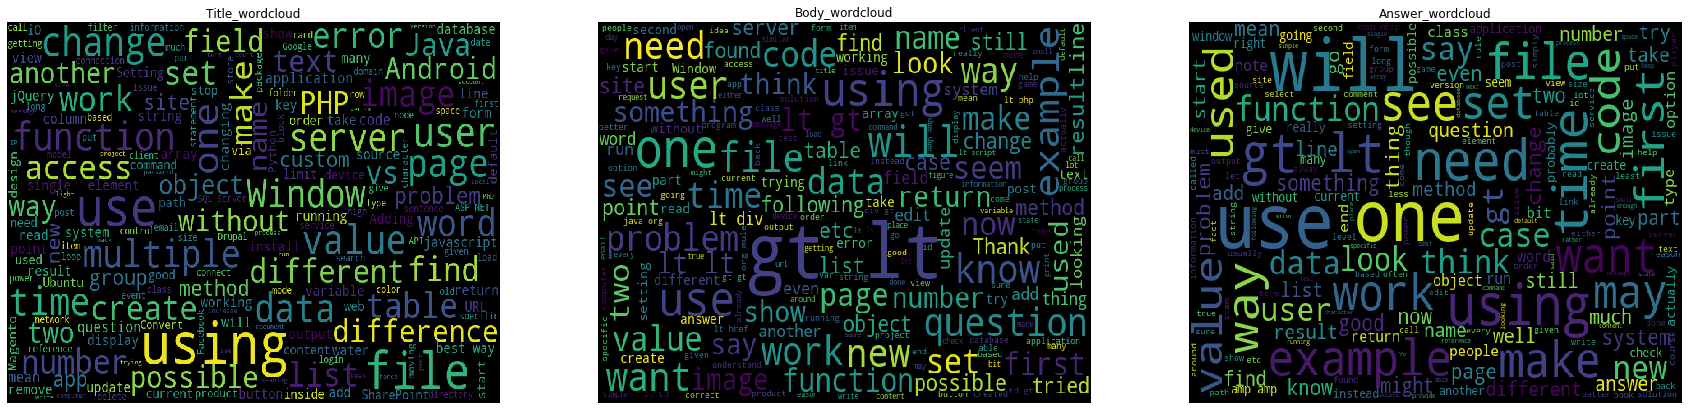

In [23]:
# 4. multi-variate analysis - comparison between title, body, answer words.
plt.figure(figsize = (30, 7))
plt.subplot(1,3,1)
plt.imshow(title_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.title('Title_wordcloud')

plt.subplot(1,3,2)
plt.imshow(body_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.title('Body_wordcloud')

plt.subplot(1,3,3)
plt.imshow(answer_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.title('Answer_wordcloud')
plt.show()

* similar sets of words and frequencies to question_title and question_body.
* Here wordcloud analysis completely ensures that questions title, body and answer are mutually related features. which is healthy sign to predict 30 question answer related target features.
* On these kinds of set of words, transfer learning is one of the best possible way out using pretrained deep learning sentence embeddings like RoBERTa, USE etc.
* question body and answer text features have to go through heavy preprocessing steps than title.

In [24]:
# 4. find duplicate answers
df_train[df_train['answer'].duplicated()].shape

(0, 41)

- No duplicate answers, which implies one question can have multiple answers. 
- i.e., if we feed question features along with answer feature then we do not need to remove duplicate 'questions_title' or 'question_body' features. 

### 4. Target features

In [25]:
# 1. no. of unique values each target feature has..
tar_features = ['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
unique_val = [len(df_train[i].unique()) for i in tar_features]
print(unique_val)

[9, 9, 5, 5, 5, 5, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 9, 9, 9, 9, 9, 17, 5, 5, 5, 9]


In [26]:
# 2. basics
df_train[tar_features].describe().iloc[1:]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
mean,0.892663,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,0.004469,...,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,0.132047,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,0.045782,...,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,0.777778,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,0.000000,...,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,0.888889,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,0.000000,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,0.000000,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
import warnings
warnings.filterwarnings('ignore')

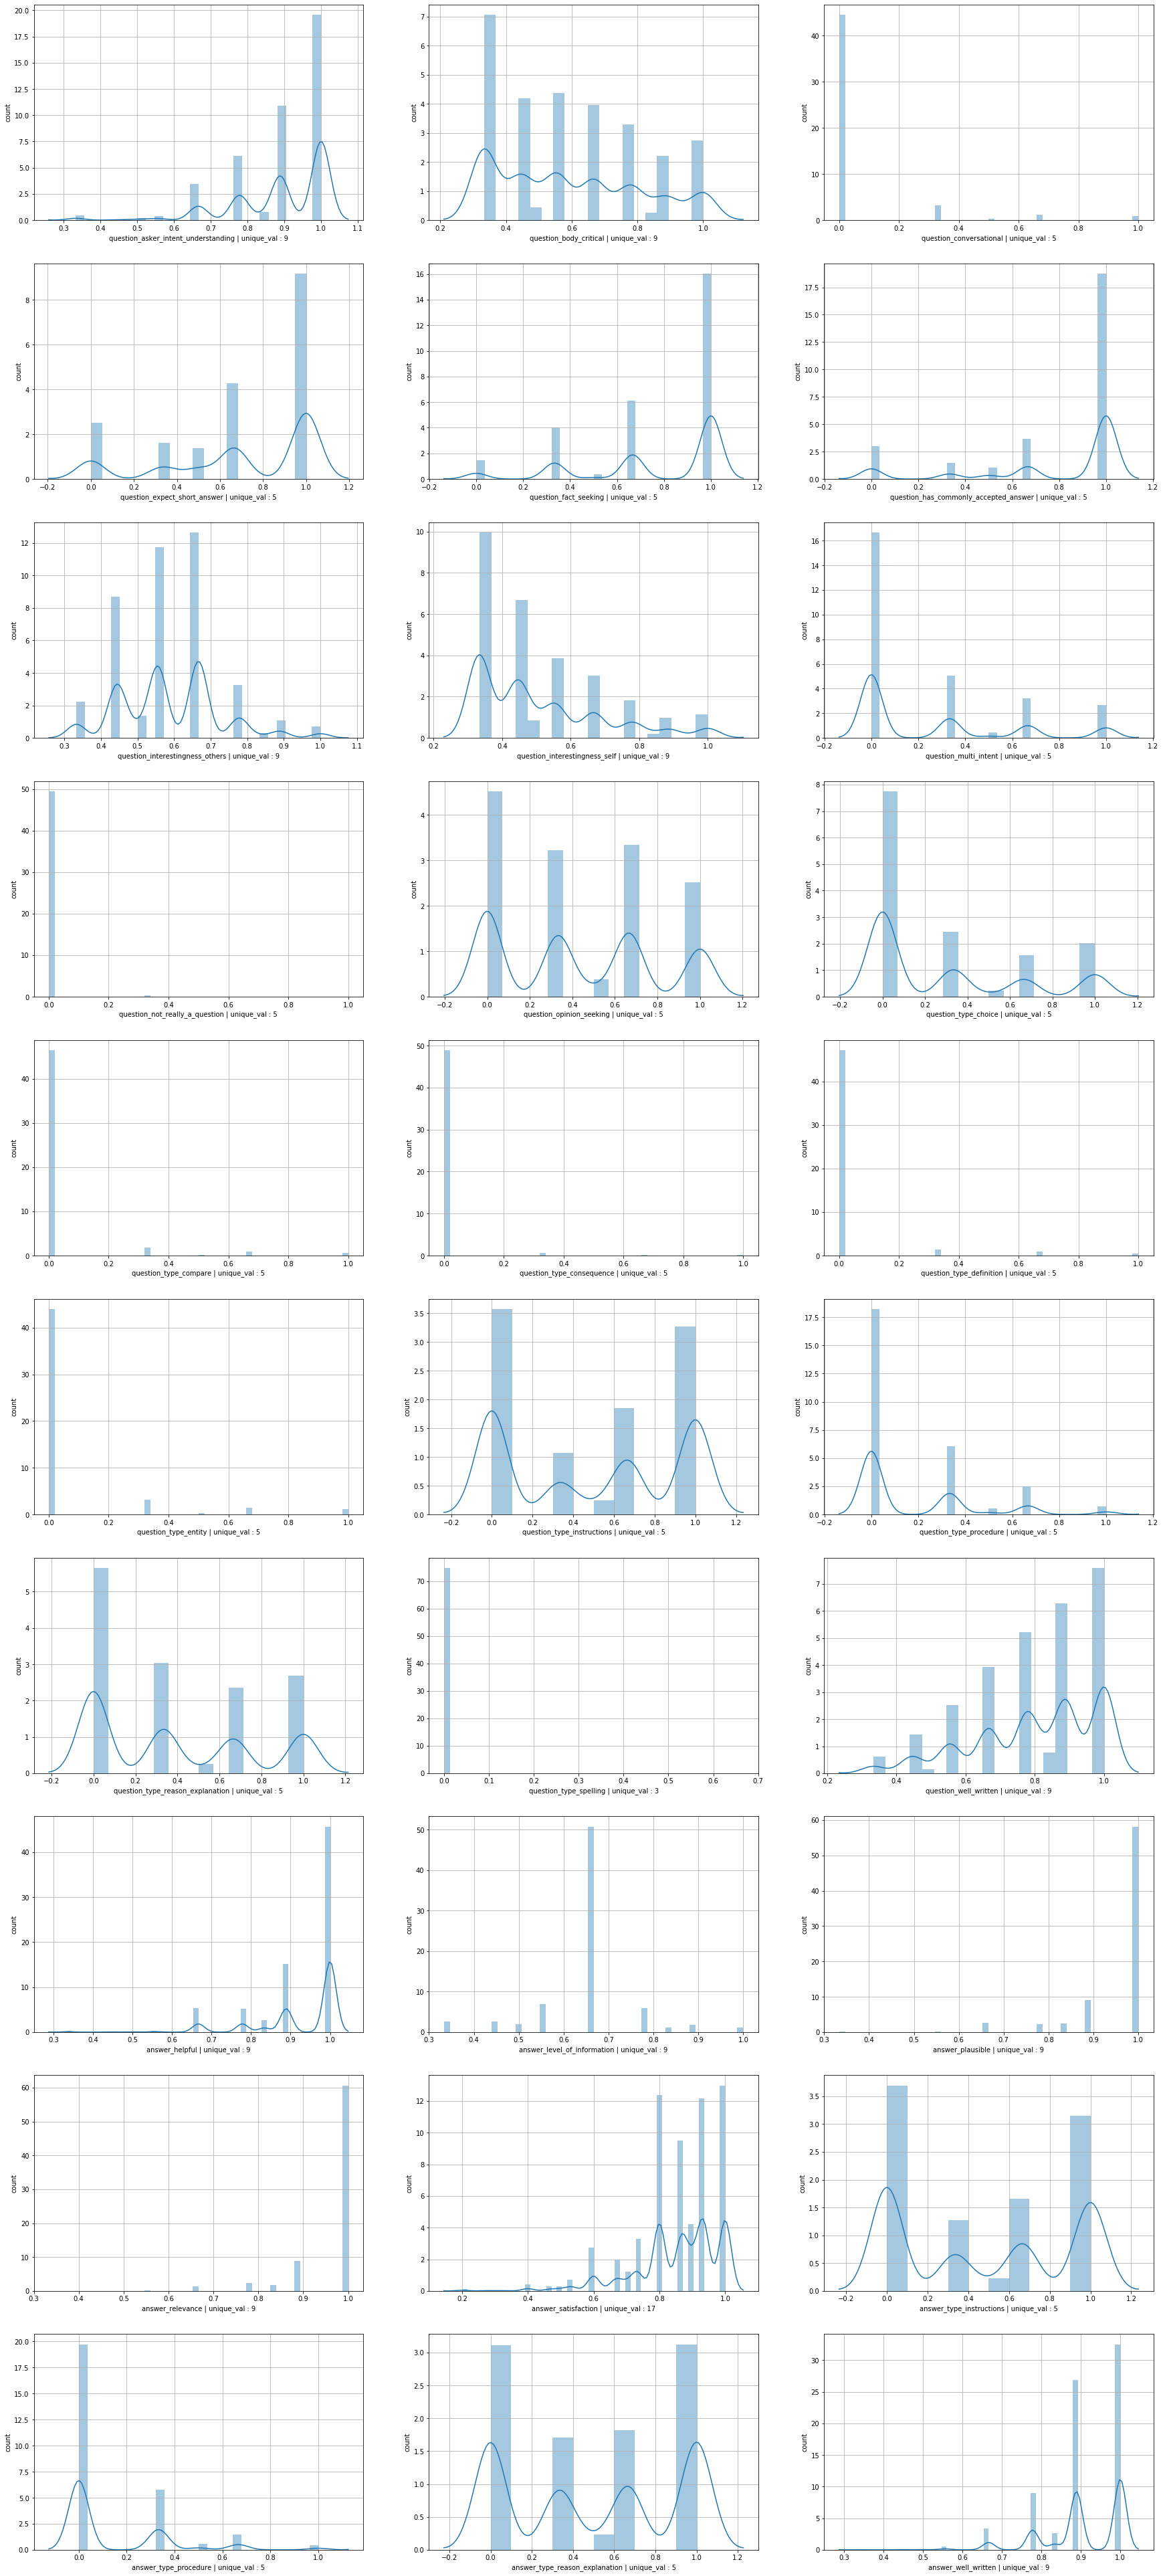

In [28]:
# 3. pdfs
plt.figure(figsize = (30, 70))
for i in range(30):
  plt.subplot(10, 3, i+1)
  column = tar_features[i]
  sns.distplot(df_train[column].values, hist = True, kde=True)
  
  plt.xlabel(column + ' | unique_val : ' + str(unique_val[i]))
  plt.ylabel('count')
  plt.grid()
plt.show()

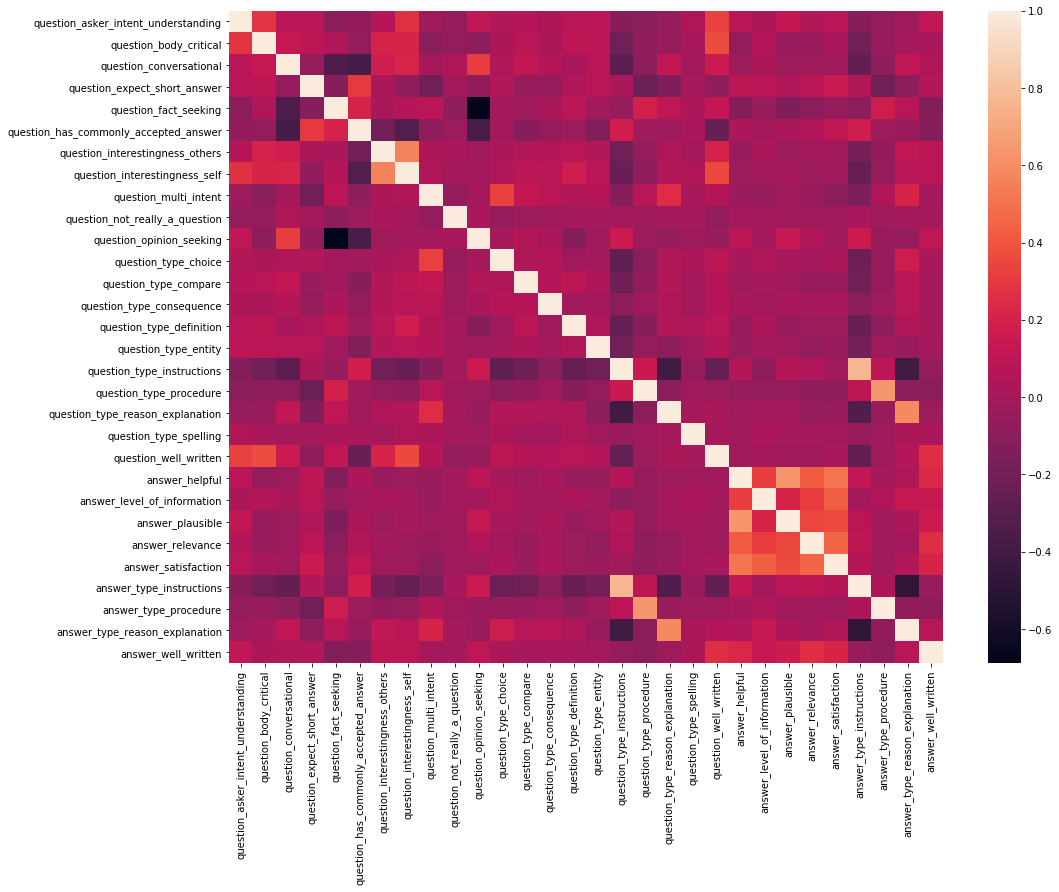

In [29]:
# 4. correlation between target features
corr = df_train[tar_features].corr(method = 'spearman')
plt.figure(figsize=(16, 12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# Observations :
1. For our task, we have 30 target feature. 21 of them are either related with 'question_title' or 'question_body' and 9 of them are related to 'answer'.
2. This is very important to note : No. of unique values in each target-features are nothing but normalized categorical ordinal ratings.
3. some target features like : 'question_conversational', 'question_not_really_a_question', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity' are highly imbalanced.
4. We found highly correlated target features like 'question_type_instruction - answer_type_instruction', 'question_type_procedure - answer_type_procedure', 'answer_helpful - answer_satisfaction'. mostly question and answer related target features are correlated, which is helpful to build a model.

# Conclusion :
1. Evaluation metric for this task is 'spearman correlation coefficient (rho)' which takes order of values in random variable into consideration.
 
  e.g. x = [0,1,2,3] , y = [5,6,7,8], z = [0.3,0.4,0.5,0.6], w = [5,5,7,7]

  rho(x, y) = 1 , rho(x, z) = 1, rho(x, w) = 0.89

2. Hence its very important to match up our regression values with target feature as part of post processing.
refer the discussion : https://www.kaggle.com/c/google-quest-challenge/discussion/118724

3. To avoid impact of imbalanced data : we need be more careful about sample or class weights while training a model. 

4. Train dataset has very small no. of datapoints to train a deep complex model. Here our task is to get good results on test data not only on train data. Hence to add up more data to existing train-set we can consider having pseudo-labelling in our training pipeline to get good results on test data.
refer : https://www.kaggle.com/c/google-quest-challenge/discussion/129840

### 5. How title, body, answer text features are useful to predict 30 target features?

In [30]:
question_tar = ['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written']
       
answer_tar = ['answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
len(question_tar), len(answer_tar)

(21, 9)

In [31]:
# 1.1. manual scores testing : defining a function
def get_titles(tar_feature = 'question_asker_intent_understanding', high_thre = 0.7, low_thre = 0.4):
    """
    This function prints high_scoring and low_scoring question titles under provided target feature.
    """
    print('high_scoring questions :', tar_feature)
    title = df_train[df_train[tar_feature] > 0.7][['question_title']].values[:5]
    score = df_train[df_train[tar_feature] > 0.7][[tar_feature]].values[:5]

    for i, j in zip(title, score):
        print(i, j)
        
    print('\nlow_scoring questions :', tar_feature)
    title = df_train[df_train[tar_feature] < 0.4][['question_title']].values[:5]
    score = df_train[df_train[tar_feature] < 0.4][[tar_feature]].values[:5]

    for i, j in zip(title, score):
        print(i, j) 

In [32]:
# 1.2. manual scores testing
for i in question_tar:
    get_titles(tar_feature = i, high_thre = 0.7, low_thre = 0.4)
    print('-'*120)

high_scoring questions : question_asker_intent_understanding
['What am I losing when using extension tubes instead of a macro lens?'] [1.]
['What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?'] [1.]
['Maximum protusion length for through-hole component pins'] [0.88888889]
['Can an affidavit be used in Beit Din?'] [0.88888889]
['How do you make a binary image in Photoshop?'] [1.]

low_scoring questions : question_asker_intent_understanding
['Disabled buttons while long running task'] [0.33333333]
['Linux Mail servers over Windows Mail servers'] [0.33333333]
['Is PC2700 ECC backwards compatible with PC2100 ECC?'] [0.33333333]
['Proper place to put shell prompt(PS1) when use sh/bash/zsh together'] [0.33333333]
['Do the online LaTeX compilers use a TeX daemon to speed up their compilation?'] [0.33333333]
------------------------------------------------------------------------------------------------------------------------
high_scor

['What am I losing when using extension tubes instead of a macro lens?'] [1.]
['sleeping SPID blocking other transactions'] [1.]
['Verify $_POST script will work correctly'] [1.]
['multiple keys via HKDF - whats better, one or two applications of HKDF-extract'] [1.]
['What filter should I use to avoid overly-whitened daylight  images?'] [1.]

low_scoring questions : question_opinion_seeking
['What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?'] [0.]
['Maximum protusion length for through-hole component pins'] [0.33333333]
['Can an affidavit be used in Beit Din?'] [0.]
['How do you make a binary image in Photoshop?'] [0.]
['How do you get your Steam games to run on Ubuntu through Wine or something similar?'] [0.]
------------------------------------------------------------------------------------------------------------------------
high_scoring questions : question_type_choice
['Can an affidavit be used in Beit Din?'] [1.]
['mult

# Observations : verification of few tar_features
* 'high_scoring' :
    1. 'high_scoring questions : question_well_written' is clearly making justice with the scores given by the raters.
    2. The questions under 'high_scoring questions : question_type_consequence' are actually asking for the consequences as an answer, and hence scores are high.
    3. one can easily tell that questions under 'high_scoring questions : question_type_compare' are asking for differences between entities, and hence scores are high.
    4. 'high_scoring questions : question_asker_intent_understanding', if question is easily understandable then score is high.


* 'low_scoring' :
    1. 'low_scoring questions : question_well_written', these questions are badly written hence their scores are low.
    2. 'low_scoring questions : question_type_consequence', these questions are not asking for consequences.
    3. 'low_scoring questions : question_type_compare', these questions are not asking for comparison as an answer.
    4. 'low_scoring questions : question_asker_intent_understanding', these questions are hard to understand the intention of asker, hence scores are low
    
# Conclusion :
    1. after getting observations of manual_scores_testing, we can eaily conclude that there is relation between question_title and 30 target features.
    
    2. Once we convert given text features into equivalent numeric form, it will be useful to predict those 30 target features.

### 6. loss function

* Which loss function to use is specific to model arhitecture we choose:
    1. for 2d output : (batch_size, 30_target_features) -
        - generally better to use 'binary_crossentropy' with 'sigmoid' activation function for output layer.
    
    2. for 3d output : (batch_size, 30, 30) -
        - generally better to use 'mean_squared_error' with 'sigmoid' activation function for output layer.
        

# 3. Data  Preprocessing

In [33]:
# Sample data_point, 
dp = 1000
df_train['question_title'][dp], df_train['question_body'][dp], df_train['answer'][dp]

('Using a Wiener Filter to Estimate a Transfer Function',
 'As a follow-on to this question about estimating a transfer function of an unknown system using a Wiener filter, \n\n\nHow would you put a minimum MSE criteria on how well the estimated filter weights matched the actual transfer function of the system? [Suppose you needed the MSE to be no more than -50dB]?\nHow would you change his formulation if you wanted poles as well as zeroes (an IIR rather than an FIR filter)?\n\n',
 "\nThe desired MSE is application dependent, so there can be no general\nrule. If the approximation doesn't satisfy your needs you can\nincrease the filter length to obtain a better match.\nThere is no straightforward way to change the FIR Wiener filter solution to an IIR solution because the IIR formulation results in a set of nonlinear equations which have no closed-form solution. The IIR solution might also be unstable, so FIR filters are a much more practical choice when computing a Wiener filter.\n\n")

**Text preprocessing pipeline :** 
 1. remove html tags, html urls, replace html comparison operators
 2. remove latex
 3. all lowercase 
 4. decontraction
 5. remove non-english-characters
 6. remove all special-characters
 7. Stop_word removal
 8. remove all white-space

In [34]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')

def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def text_preprocessor(column, remove_stopwords = False, remove_specialchar = False):
  """pass any column with Text in it from df_train | Note: returns nothing makes inplace changes in df_train"""
  # 1. remove html tags, html urls, replace html comparison operators
  text = df_train[column].values
  df_train[column] = [re.sub('<.*?>', '', i) for i in text]
  df_train[column] = df_train[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')

  # 2. remove latex i,e., if there is any formulas or latex we have to remove it
  df_train[column] = [re.sub('\$.*?\$', '', i) for i in text]

  # 3. all lowercase 
  df_train[column] = df_train[column].str.lower()

  # 4. decontractions
  df_train[column] = df_train[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")
  
  # 5. removing non-english or hebrew characters
  df_train[column] = [i.encode("ascii", "ignore").decode() for i in text]

  # 6. remove all special-characters other than alpha-numericals
  if remove_specialchar == True:
    df_train[column] = [re.sub('\W', ' ', i) for i in text]

  # 7. Stop_word removal
  if remove_stopwords == True:
    df_train[column] = [stopwrd_removal(i) for i in text]

  # 8. remove all white-space i.e., \n, \t, and extra_spaces
  df_train[column] = df_train[column].str.replace("\n", " ").str.replace("\t", " ").str.rstrip()
  df_train[column] = [re.sub('  +', ' ', i) for i in text]

### 4.1. Question title | 4.2. Question body | 4.3. answer

In [36]:
df_train['clean_title'] = df_train['question_title']
df_train['clean_body'] = df_train['question_body']
df_train['clean_answer'] = df_train['answer']
text_preprocessor('clean_title')
text_preprocessor('clean_body')
text_preprocessor('clean_answer')

##### sample datapoints after text_preprocessing

In [38]:
text = df_train['question_title'].values
print('TITLE : ', text[0:5], '\n')

text = df_train['clean_title'].values
print('CLEAN_TITLE : ',text[0:5], '\n')

text = df_train['question_body'].values
print('BODY : ', text[0:5], '\n')

text = df_train['clean_body'].values
print('CLEAN_BODY : ',text[0:5], '\n')

text = df_train['answer'].values
print('ANSWER : ', text[0:5], '\n')

text = df_train['clean_answer'].values
print('CLEAN_ANSWER : ', text[0:5])

TITLE :  ['What am I losing when using extension tubes instead of a macro lens?'
 'What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?'
 'Maximum protusion length for through-hole component pins'
 'Can an affidavit be used in Beit Din?'
 'How do you make a binary image in Photoshop?'] 

CLEAN_TITLE :  ['what am i losing when using extension tubes instead of a macro lens?'
 'what is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?'
 'maximum protusion length for through-hole component pins'
 'can an affidavit be used in beit din?'
 'how do you make a binary image in photoshop?'] 

BODY :  ['After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. Thi